In [3]:
from tqdm import tqdm
import random as rand
import numpy as np
import time
import copy

# Plotting Packages
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
# value iteration algorithm
class ValueIteration():
    """
    Value Iteration
    - In the paper, the states are represented by 1-based indexing
    - In the code, we will be using 0-based indexing
    """

    def __init__(self, exp_info = {}):
        """Initialization method for the class"""

        # Defining the number of states & actions
        self.num_states  = 25
        self.num_actions = 4
        
        # Defining the rewards
        # The rewards are independent of the action
        self.rewards =[
                [-2,-2, -10, -10, -2],
                [-2, -10, -10, -10,-2],
                [+10, -2,-2, -10, -2],
                [-1, -1, -2, -5,-2],
                [-10,-2,-2,-1,-1]
                
            ]

        # Definining the Initial State Value function
        self.S = np.zeros((5, 5))
    

        # Defining a random generator
        self.rng = np.random.RandomState(exp_info.get("seed", 0))

        # Defining the experiment parameters
        self.delta     = exp_info.get("delta", 1e-2)
        self.max_iters = exp_info.get("max_iters", 100)
        self.discount  = exp_info.get("discount", 1)

 
    def _get_new_state(self, state, action):
        
        """state is a list of 2 indices"""
        new_state = [-1, -1]

        # Any action from terminal state will lead the agent back to the terminal state
        if state == [2, 0]:
            new_state = [2, 0]

        # Moving left
        elif action == 0:
            new_state[0] = state[0]
            new_state[1] = max(0, state[1] - 1)

        # Moving up
        elif action == 1:
            new_state[0] = max(0, state[0] - 1)
            new_state[1] = state[1]

        # Moving right
        elif action == 2:
            new_state[0] = state[0]
            new_state[1] = min(3, state[1] + 1)

        # Moving down
        elif action == 3:
            new_state[0] = min(3, state[0] + 1)
            new_state[1] = state[1]

        return new_state
        
    def iterate(self):
        """Performs the iterations over the state space"""

        # Initializing some variables
        n = 0
        temp_delta = self.delta

        while temp_delta >= self.delta and n < self.max_iters:
            temp_delta = 0
            
            # A single sweep over the state space
            for state in np.ndindex(self.S.shape):
                
                max_val = 1e-5
                for a in range(self.num_actions):
                    # Calculating the value for a (S, A) pair
                    
                    s_prime= self._get_new_state(state, a) 
                    
                    temp_val=self.rewards[s_prime[0]][s_prime[1]] + self.discount * self.S[s_prime[0]][s_prime[1]] 
                    
                    max_val = max(max_val, temp_val)

                temp_delta = max(temp_delta, abs(max_val - self.S[state[0]][state[1]]))
                self.S[state[0]][state[1]] = max_val

            n += 1

            ### DEBUG CODE
            # print(temp_delta, self.s_vals)

        return self.S
    
    def plot_states(self):
        # This is done just to represent the values in the correct format
        arr = np.flip(self.S, axis = 0)

        fig, ax = plt.subplots(1, 1, figsize = (6, 6))
        ax.axis('on')
        ax.cla()
        im = ax.imshow(arr, cmap='Reds', vmin=np.min(arr), vmax=np.max(arr), aspect='auto')
        ax.invert_yaxis()
        ax.set_title('Value Function')
        plt.xticks([])
        plt.yticks([])
        ax.grid(which='both')

        # Adding Text
        text_arr = self.S.T
        text_arr = np.flip(text_arr, axis = 1)
        for i, j in np.ndindex(self.S.shape):
            ax.text(
                i, j, f"{np.round(text_arr[i][j], 2)}", horizontalalignment='center',
                verticalalignment='center',fontsize=12
            )

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.20)
        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
        cbar.set_label('Value', rotation=0, ha='left')

        fig.subplots_adjust(wspace=0.5)
        display.display(fig)
        plt.close()

    #finding optimal policy corresponding to the state values
    def finding_policy(self):
        pi =np.zeros((5, 5))
        
        for state in np.ndindex(self.S.shape):

            max_val = 1e-5
            for a in range(self.num_actions):

                s_prime= self._get_new_state(state, a) 

                temp_val=self.rewards[s_prime[0]][s_prime[1]] + self.discount * self.S[s_prime[0]][s_prime[1]] 

                if(temp_val>max_val):
                    pi[state[0]][state[1]]=a
                    max_val=temp_val
                   
        return pi
    
    def plot_policy(self,pi):
        # This is done just to represent the values in the correct format
        arr = np.flip(self.S, axis = 0)

        # actions according to the policy
        actions = pi

        fig, ax = plt.subplots(1, 1, figsize = (6, 6))
        ax.axis('on')
        ax.cla()
        im = ax.imshow(arr, cmap='Reds', vmin=np.min(arr), vmax=np.max(arr), aspect='auto')
        ax.invert_yaxis()
        ax.set_title('Optimal Policy')
        plt.xticks([])
        plt.yticks([])
        ax.grid(which='both')

        # Adding Text
        text_arr = actions.T
        text_arr = np.flip(text_arr, axis = 1)
        for i, j in np.ndindex(actions.shape):
            act = "<---"

            # Setting the Degrees of Rotation
            if text_arr[i][j] == 0: degrees = 0
            elif text_arr[i][j] == 1: degrees = -90
            elif text_arr[i][j] == 2: degrees = 180
            elif text_arr[i][j] == 3: degrees = 90

            ax.text(
                i, j, f"{act}", horizontalalignment='center',
                verticalalignment='center',fontsize=12, rotation = degrees
            )

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.20)
        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
        cbar.set_label('Value', rotation=0, ha='left')

        fig.subplots_adjust(wspace=0.5)
        display.display(fig)
        plt.close()

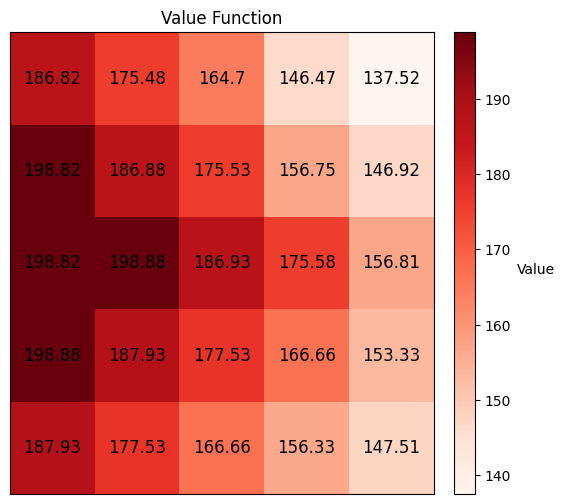

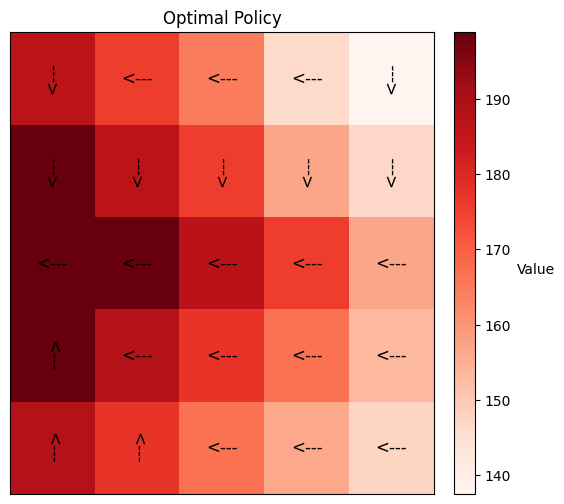

In [5]:
# feed the parameter and run value iteration algorithm
exp_info = {
    'delta': 1e-2,
    'max_iters': 100,
    'discount': 0.95
}

env = ValueIteration(exp_info)
s_val = env.iterate()
env.plot_states()
Pi_optimal=env.finding_policy()
env.plot_policy(Pi_optimal)